<a href="https://colab.research.google.com/github/drorb1987/mafat/blob/main/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Download the training dataset and import packages

**Please notice that after Matplotlib package install (row number 4), you need to restart the runtime.**

In [ ]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/14MDE3RUpRMeUJ8VpI5BMFAZG-xnfon7B/view?usp=share_link'

Downloading...
From: https://drive.google.com/uc?id=14MDE3RUpRMeUJ8VpI5BMFAZG-xnfon7B
To: /content/train_dataset.zip
100% 3.25G/3.25G [00:40<00:00, 79.8MB/s]


In [ ]:
!unzip '/content/train_dataset.zip'

Archive:  /content/train_dataset.zip
   creating: images/
  inflating: images/16730_3840_1280.tiff  
  inflating: images/5248_7680_3840.tiff  
  inflating: images/11731_3840_1280.tiff  
  inflating: images/18029_5120_6400.tiff  
  inflating: images/2405_0_3840.tiff  
  inflating: images/18029_6400_6400.tiff  
  inflating: images/14390_6400_0.tiff  
  inflating: images/9248_0_2560.tiff  
  inflating: images/17314_6400_2560.tiff  
  inflating: images/18425_2560_0.tiff  
  inflating: images/12575_5120_6400.tiff  
  inflating: images/271_5120_6400.tiff  
  inflating: images/18205_0_2560.tiff  
  inflating: images/4296_5120_0.tiff  
  inflating: images/12270_5120_0.tiff  
  inflating: images/5809_0_6400.tiff  
  inflating: images/7419_6400_1280.tiff  
  inflating: images/8557_6400_5120.tiff  
  inflating: images/17396_7680_5120.tiff  
  inflating: images/6143_6400_1280.tiff  
  inflating: images/2438_2560_17920.tiff  
  inflating: images/4079_2560_6400.tiff  
  inflating: images/755_3840_38

In [ ]:
!pip install matplotlib==3.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib as mpl
import seaborn as sns
from decimal import *
import os
import math

In [ ]:
#Uniform color map for the classes (to display graphs below)
color_class = {'small_vehicle':'r', 'bus':'g', 'medium_vehicle':'b', 'large_vehicle':'c', 'double_trailer_truck':'m', 'container':'y',
'pylon':'k', 'small_aircraft':'purple', 'large_aircraft':'brown', 'small_vessel':'orange', 'medium_vessel':'pink', 'large_vessel':'olive',
               'heavy_equipment':'tab:olive'}

#Settings for charts display (below)
mpl.rcParams['font.size'] = '22'
mpl.rcParams['figure.figsize'] = [35,8]
mpl.rcParams["figure.subplot.hspace"] = 0.9
mpl.rcParams["figure.subplot.wspace"] = 0.5

##**Functions**

In [ ]:
def read_annotations(path_to_labelTxt):
    """
    Read the annotation files(txt) and create a data frame and a list that include the frames' names.

    Parameters
    ----------
    path_to_labelTxt : str
        The files location of the annotations.

    Returns
    -------
    dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name.
    list    
        A list that includes the frames' names.
    """
    list_annotations_files = []
    list_frame_names = []
    columns_names = ['x1','y1','x2','y2','x3','y3','x4','y4' ,'category_id']

    # iterate over files in the directory
    labelTxt_files = os.listdir(path_to_labelTxt)
    for filename in labelTxt_files:

        df = pd.read_csv(os.path.join(path_to_labelTxt, filename), sep=" ", header=None, names=columns_names)
        frame_name = filename.split(".")[0]
        df["Frame"] = frame_name
        list_annotations_files.append(df)
        list_frame_names.append(frame_name)

    ann_train = pd.concat(list_annotations_files)
    ann_train.reset_index(drop = True, inplace = True)

    return ann_train,list_frame_names

In [ ]:
def bb_out_of_frame(annotations, start_range_frame=0, stop_range_frame=1280):
    """
    Count the annotations (bounding boxes) that cross the frame size.

    Parameters
    ----------
    annotations : dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name.
    start_range_frame : int
        The lower limit range of square frame size.
    stop_range_frame = int
        The upper limit range of square frame size.

    Returns
    -------
    int
        The number of annotations (bounding boxes) that cross the frame size.
    """
    out_of_frame = annotations.loc[(annotations.x1<start_range_frame) | (annotations.x1>stop_range_frame) | (annotations.x2<start_range_frame) | (annotations.x2>stop_range_frame)| (annotations.x3<start_range_frame) | (annotations.x3>stop_range_frame) | (annotations.x4<start_range_frame) | (annotations.x4>stop_range_frame) | 
                    (annotations.y1<start_range_frame) | (annotations.y1>stop_range_frame) | (annotations.y2<start_range_frame) | (annotations.y2>stop_range_frame)| (annotations.y3<start_range_frame) | (annotations.y3>stop_range_frame) | (annotations.y4<start_range_frame) | (annotations.y4>stop_range_frame)]
    return out_of_frame


In [ ]:
def anno_vis_bar(annotations):
    """
    Visualization of total annotations per class

    Parameters
    ----------
    annotations : dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name..

    Returns
    -------
    -
    """
    ax = sns.countplot(data=annotations, y='category_id', order = annotations['category_id'].value_counts().index, palette = color_class)
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{x:.0f}' for x in container.datavalues])
    ax.set_ylabel('category_id')
    ax.set_xlabel('annotation count')
    plt.title('Total annotations per class')
    plt.show()

In [ ]:
def anno_bb_out_of_frame_vis_bar(annotations):
    """
    Visualization of total annotations per class that cross the frame shape.

    Parameters
    ----------
    annotations : dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name..

    Returns
    -------
    -
    """

    out_of_frame = bb_out_of_frame(annotations)
    sns.countplot(out_of_frame.category_id, order = out_of_frame['category_id'].value_counts().index, palette = color_class)
    plt.title('BB partial out of frame per class')
    plt.xticks(rotation=70)

In [ ]:
def class_per_img_hist(annotations):
    """
    Visualization of number of frames per number of objects per class.

    Parameters
    ----------
    annotations : dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name..

    Returns
    -------
    -
    """
    #GroupBy df by Frame and classes for counting each category in each frame.
    ann_classes = annotations.groupby(['Frame','category_id'])['category_id'].count()
    ann_classes = ann_classes.to_frame()
    ann_classes = ann_classes.rename(columns ={'category_id':'count'}).reset_index()

    plt.subplots_adjust(hspace=1.8, wspace= 0.5)
    plt.suptitle('Number of frames per number of objects per class')#, fontsize=20)

    #Create dataframes of classes counting in all the frames for histogram visualization.
    for i,c in enumerate(class_obj):
        ax = plt.subplot(3, 5, i + 1)
        obj_df = ann_classes.loc[ann_classes.category_id == c]
        ax.set_title(c)
        ax.hist(obj_df['count'], bins = np.arange(1, obj_df['count'].max()+2), color = color_class[c])
        ax.set_xlabel(f'num_of_objects')
        ax.set_ylabel('num_of_\nframes')

In [ ]:
def hist_features(metadata, f, bin_size):
    """
    Histogram of the number of frames per aoi.

    Parameters
    ----------
    metadata : dataframe
        Frames' metadata includes: Frame name, AOI, Resolution, Sun_Elevation, Azimuth, Sun_Azimuth, Hermetic_Small_Vehicle
    f : str
        Selected feature for histogram display.
    bin_size : int
        The range size of each bar in the histogram.

    Returns
    -------
    -
    """
    if f == 'AOI':
        metadata.loc[metadata.AOI =='unspecified', 'AOI'] = 23.0
        metadata['AOI'] = metadata.AOI.astype('float')

        bins=np.arange(metadata.AOI.min(), metadata.AOI.max()+2)
        x_ticks = np.append(bins[:-2], np.array(['unspecified']))


        fig, ax = plt.subplots()
        plt.title(f"Frames per {f} Histogram")
        _, edges, _ = ax.hist(x=f, data=metadata, bins=bins)
        ticks  = edges[:-1] + np.diff(edges) / 2

        ax.set_xticks(ticks)
        ax.set_xticklabels(x_ticks, rotation=40)
        plt.ylabel('Counts')
        plt.xlabel(f)
        metadata.loc[metadata.AOI ==23.0, 'AOI'] = 'unspecified'
    else:
        if bin_size>1:
            res_min = math.floor(metadata[f].min()/10)*10
            res_max = math.ceil(metadata[f].max()/10)*10
        else:
            res_min = math.floor(metadata[f].min()*10)/10
            res_max = math.ceil(metadata[f].max()*10)/10

        bins = np.arange(res_min, res_max+2*bin_size, bin_size)
        x_ticks = np.arange(res_min, res_max+bin_size,bin_size)

        fig, ax = plt.subplots()
        plt.title(f"Frames per {f} Histogram")
        plt.hist(x=f, data=metadata, bins=bins)

        plt.xticks(x_ticks)
        plt.ylabel('Counts')
        plt.xlabel(f)


In [ ]:
def box_plot_aoi(metadata, f):
    """
    Box plot of the feature in different aoi.

    Parameters
    ----------
    metadata : dataframe
        Frames' metadata includes: Frame name, AOI, Resolution, Sun_Elevation, Hermetic_Small_Vehicle
    f : str
        Feature selected to visualize its box plot in each aoi.

    Returns
    -------
    -
    """
    metadata.loc[metadata.AOI =='unspecified', 'AOI'] = 23.0
    metadata['AOI'] = metadata.AOI.astype('float')

    g = sns.boxplot(data=metadata, x="AOI", y=f, color="green", saturation = 2.7)

    xtickes = [t.get_text()  for t in g.get_xticklabels()]
    xtickes[-1] = 'unspecified'
    g.set_xticklabels(xtickes)

    plt.title(f"Box plot of {f} for each AOI")
    plt.show()

    metadata.loc[metadata.AOI ==23.0, 'AOI'] = 'unspecified'


In [ ]:
def total_ann_heatmap(annotations):
    """
    Heatmap of the number of the class's annotations in each AOI.

    Parameters
    ----------
    annotations : dataframe
        A dataframe of the annotations includes 4 points of the bounding box of the annotation, category_id, and Frame name.

    Returns
    -------
    -
    """
    annotations.loc[annotations.AOI =='unspecified', 'AOI'] = 23.0
    annotations['AOI'] = annotations.AOI.astype('float')

    #GroupBy df by AOI and classes for counting each category in each AOI
    class_count_aoi = annotations.groupby(['AOI','category_id'])['category_id'].count()
    class_count_aoi = class_count_aoi.to_frame()
    class_count_aoi = class_count_aoi.rename(columns ={'category_id':'count_each_class'}).reset_index()

    #Create custom df of classes in each region for heatmap visualization
    list_aoi = []
    for aoi_num in class_count_aoi.AOI.unique():
        slice_aoi = class_count_aoi[class_count_aoi.AOI==aoi_num]
        slice_aoi = slice_aoi[['category_id','count_each_class']].T
        slice_aoi.columns = slice_aoi.iloc[0,:]
        slice_aoi.drop(index = 'category_id', axis = 0, inplace = True)
        slice_aoi.insert(0, 'AOI', [aoi_num])
        list_aoi.append(slice_aoi)

    class_count_aoi_df = pd.concat(list_aoi, axis = 0)
    class_count_aoi_df.reset_index(drop = True, inplace = True)
    class_count_aoi_df.fillna(0.0, inplace = True)
    class_count_aoi_df = class_count_aoi_df.astype('float')
    class_count_aoi_df['AOI'] = class_count_aoi_df.AOI.astype('int')
    class_count_aoi_df.set_index(['AOI'], drop = True, inplace =True)

    plt.figure(figsize = (20,14))
    plt.title("Total annotations in each region AOI")
    g = sns.heatmap(class_count_aoi_df[class_obj],  annot=True ,annot_kws={"fontsize":14},fmt=".0f", linewidth=.5, vmin=0, vmax=class_count_aoi.count_each_class.max(), cmap='pink')

    ytickes = [t.get_text()  for t in g.get_yticklabels()]
    ytickes[-1] = 'unspecified'
    g.set_yticklabels(ytickes, rotation = 30)

    annotations.loc[annotations.AOI ==23.0, 'AOI'] = 'unspecified'



In [ ]:
def heatmap_res(annotations):
    """
    Heatmap of the Resolution distribution for each class.

    Parameters
    ----------
    annotations : dataframe
        Annotations dataframe includes category_id and Resolution.

    Returns
    -------
    -
    """
    #Setting the resolution range in 0.1 increments
    res_min = math.floor(annotations.Resolution.min()*10)/10
    res_max = math.ceil(annotations.Resolution.max()*10)/10
    bins = np.arange(res_min, res_max+0.1, 0.1)

    #Create a custom df of resolution for each class for heatmap visualization
    category_resolution_list = []
    for c in class_obj:
        tagged_df_copy_class = annotations[annotations.category_id ==c]
        tagged_df_copy_class.reset_index(drop=True, inplace=True)
        category_df = pd.cut(x = tagged_df_copy_class.Resolution,bins = bins.tolist(), include_lowest=True)
        category_df_normalize = category_df.value_counts(normalize=True)
        category_df_normalize = category_df_normalize.to_frame().rename(columns = {"Resolution":c})
        category_resolution_list.append(category_df_normalize)   

    category_resolution = pd.concat(category_resolution_list, axis = 1)
    
    plt.figure(figsize = (14,14))
    plt.title("Resolution Distribution for each class")
    sns.heatmap(category_resolution.T)

In [ ]:
def frame_with_annotation(frame_path, ann_frame):
    """
    Display of the selected frame and its annotations.

    Parameters
    ----------
    img_path : str
        The file location of the frame.
    ann_img : str
        The location of the corresponding annotations file to the frame.
    Returns
    -------
    -
    """
    try:
        img = Image.open(frame_path)
    except:
        print("Wrong frame name")
        return

    fig, ax = plt.subplots(1, figsize=(15, 15))

    # Display the image
    ax.imshow(img, cmap = 'gray')
    ax.grid(False)

    for index, row in ann_frame.iterrows():
        class_color = color_class[row['category_id']]

        rec_coor = [[row['x1'],row['y1']], [row['x2'],row['y2']], [row['x3'],row['y3']], [row['x4'],row['y4']]]
        # Create a Rectangle patch
        rect = patches.Polygon(rec_coor, linewidth=2.0,
                                edgecolor=class_color, facecolor="none")
        ax.add_patch(rect)

    plt.show()

##**Data Loading and preparation**

In [ ]:
path_to_labelTxt = '/content/labelTxt'

In [ ]:
#annotations
ann_train, list_frame_names = read_annotations(path_to_labelTxt)

In [ ]:
#metadata
metadata = pd.read_csv('/content/metadata_train.csv')
metadata.head()

,Frame,AOI,Resolution,Sun_Elevation,Azimuth,Sun_Azimuth,Hermetic_Small_Vehicle
0,14919_7680_3840,18.0,0.566424,29.106553,216.900,80.637006,False
1,10669_11520_1280,1.0,0.550550,30.181605,148.021,263.888325,True
2,5532_6400_1280,6.0,0.906060,16.340163,227.534,281.511047,False
3,16340_7680_0,10.0,0.511862,53.173852,318.679,102.535913,True
4,13409_3840_3840,12.0,0.808492,62.278175,322.813,134.898195,True


In [ ]:
#classes
class_obj = list(ann_train.category_id.unique())

##**EDA**

###**Annotations Analysis**

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Tagged frames with objects', 'Frames without any objects', 
                 'Total num annotations', 'Number of bounding boxes out of frame'])
t.add_row([ann_train.Frame.nunique(), len(list_frame_names) - ann_train.Frame.nunique(), len(ann_train), len(bb_out_of_frame(ann_train))])
print(t)

+----------------------------+----------------------------+-----------------------+---------------------------------------+
| Tagged frames with objects | Frames without any objects | Total num annotations | Number of bounding boxes out of frame |
+----------------------------+----------------------------+-----------------------+---------------------------------------+
|            1080            |            377             |         18113         |                  710                  |
+----------------------------+----------------------------+-----------------------+---------------------------------------+


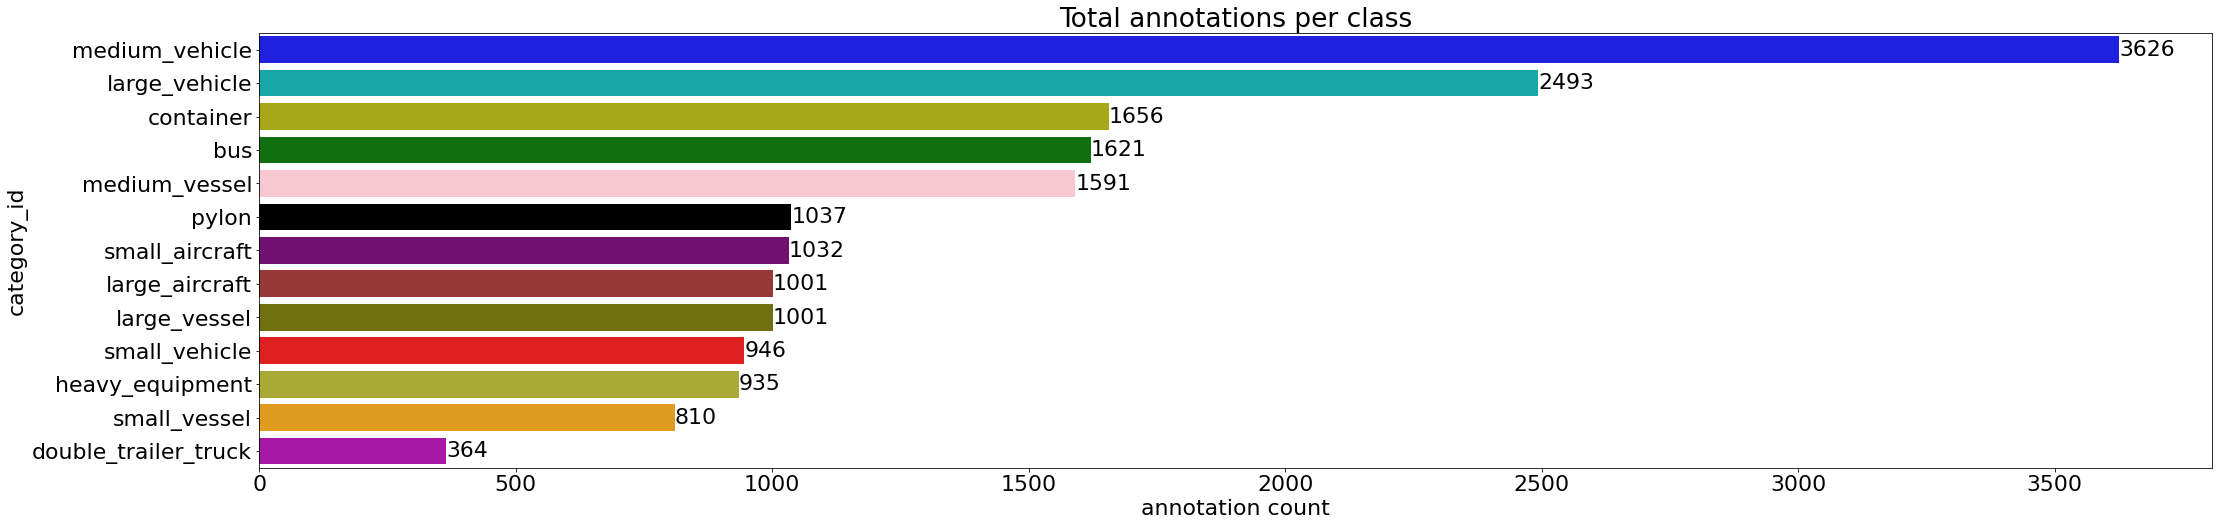

In [ ]:
anno_vis_bar(ann_train)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


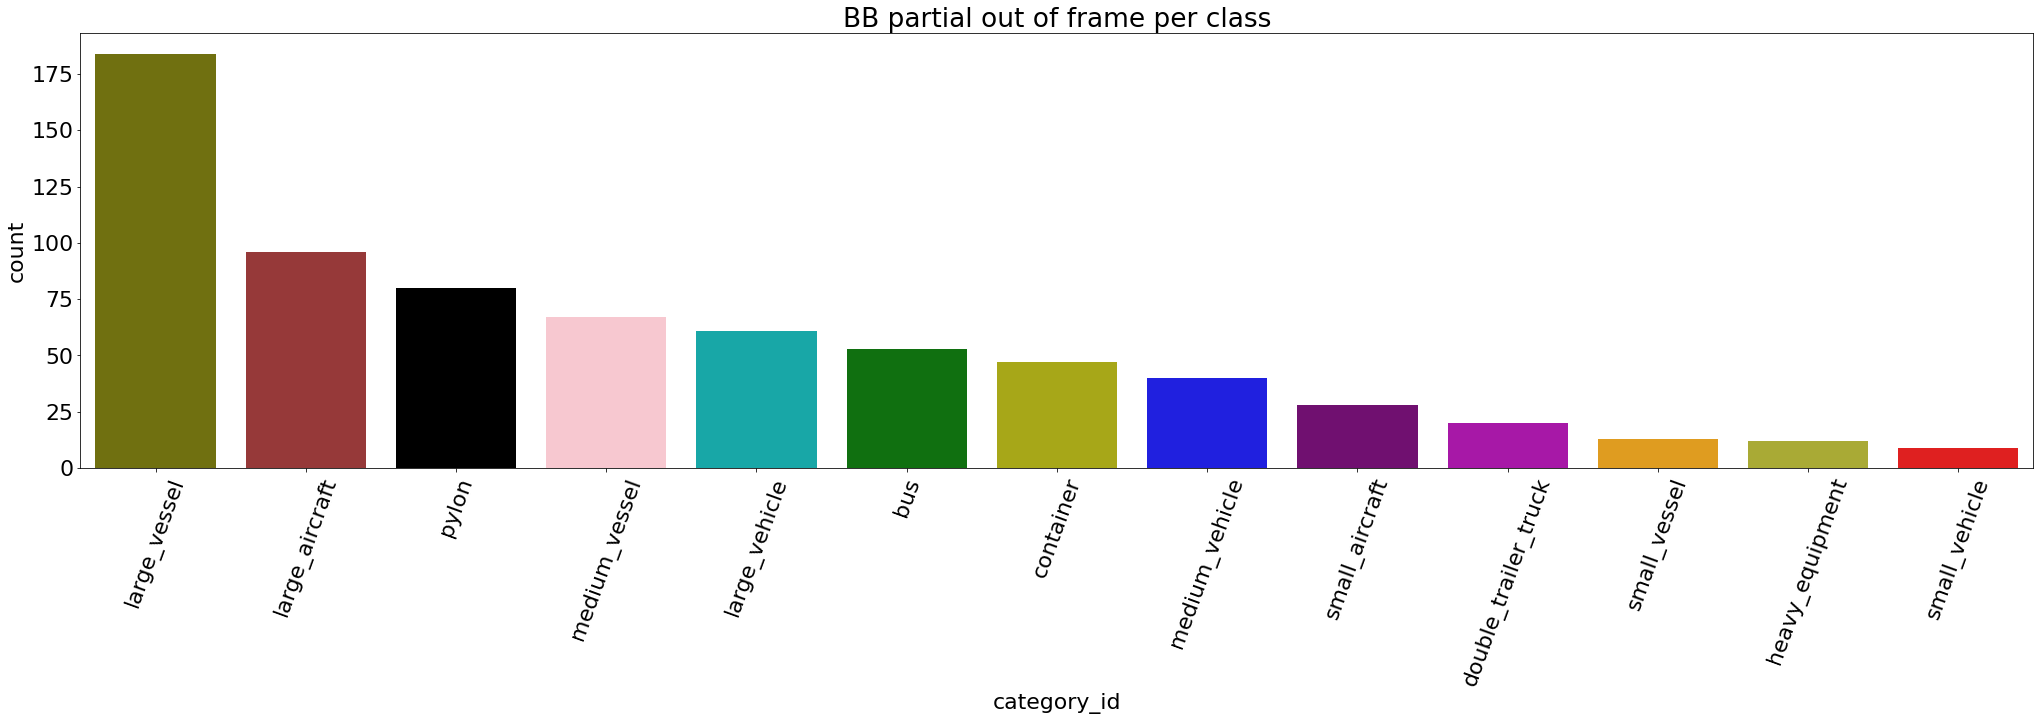

In [ ]:
anno_bb_out_of_frame_vis_bar(ann_train)

'An example for chart clarification: \nin the double trailer truck histogram, there are about 26 frames with one double trailer,\n10 frames with two double trailer,four frames with three double trailers, and on.'

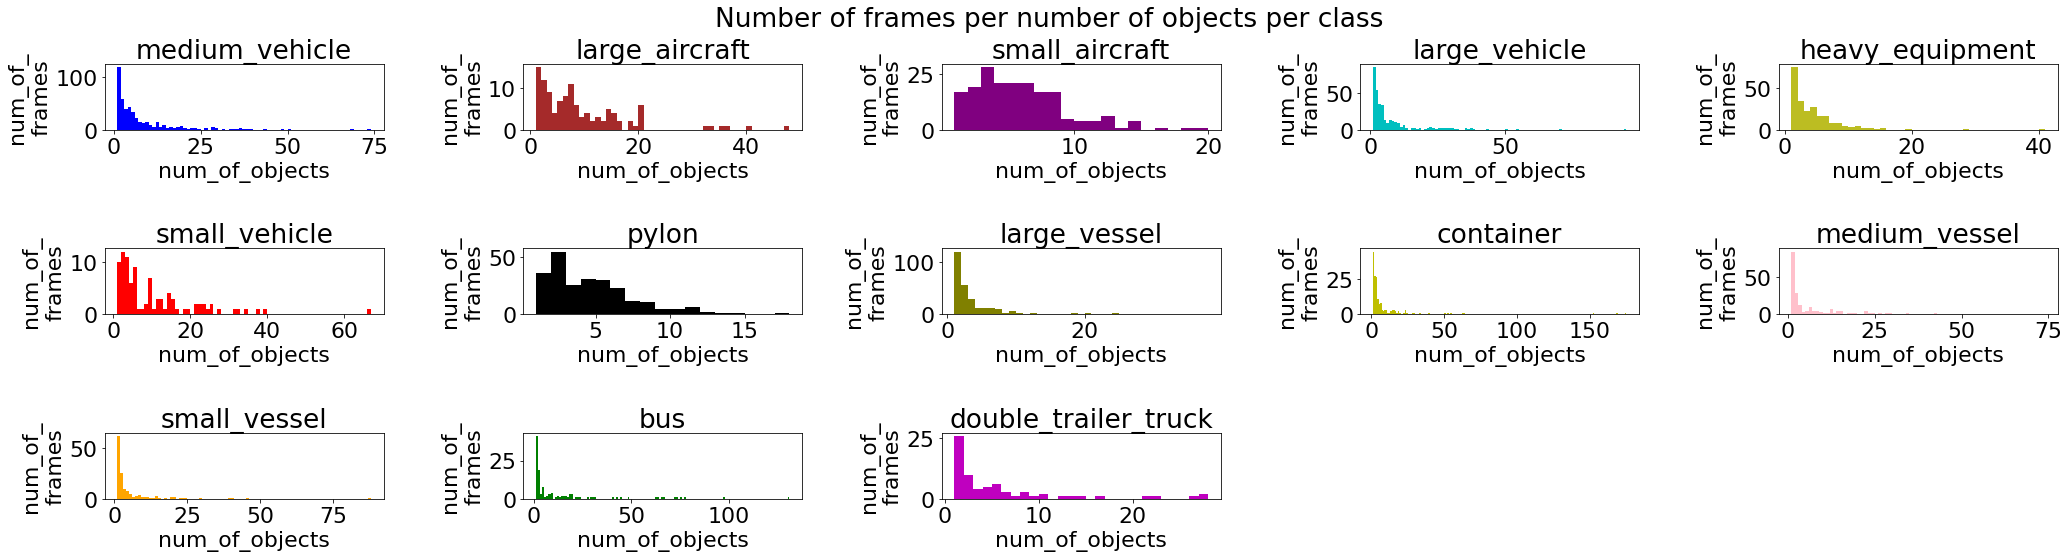

In [ ]:
class_per_img_hist(ann_train)

"""An example for chart clarification: 
in the double trailer truck histogram, there are about 26 frames with one double trailer,
10 frames with two double trailer,four frames with three double trailers, and on."""

###**Metadata Analysis**

####**Frames Analysis**

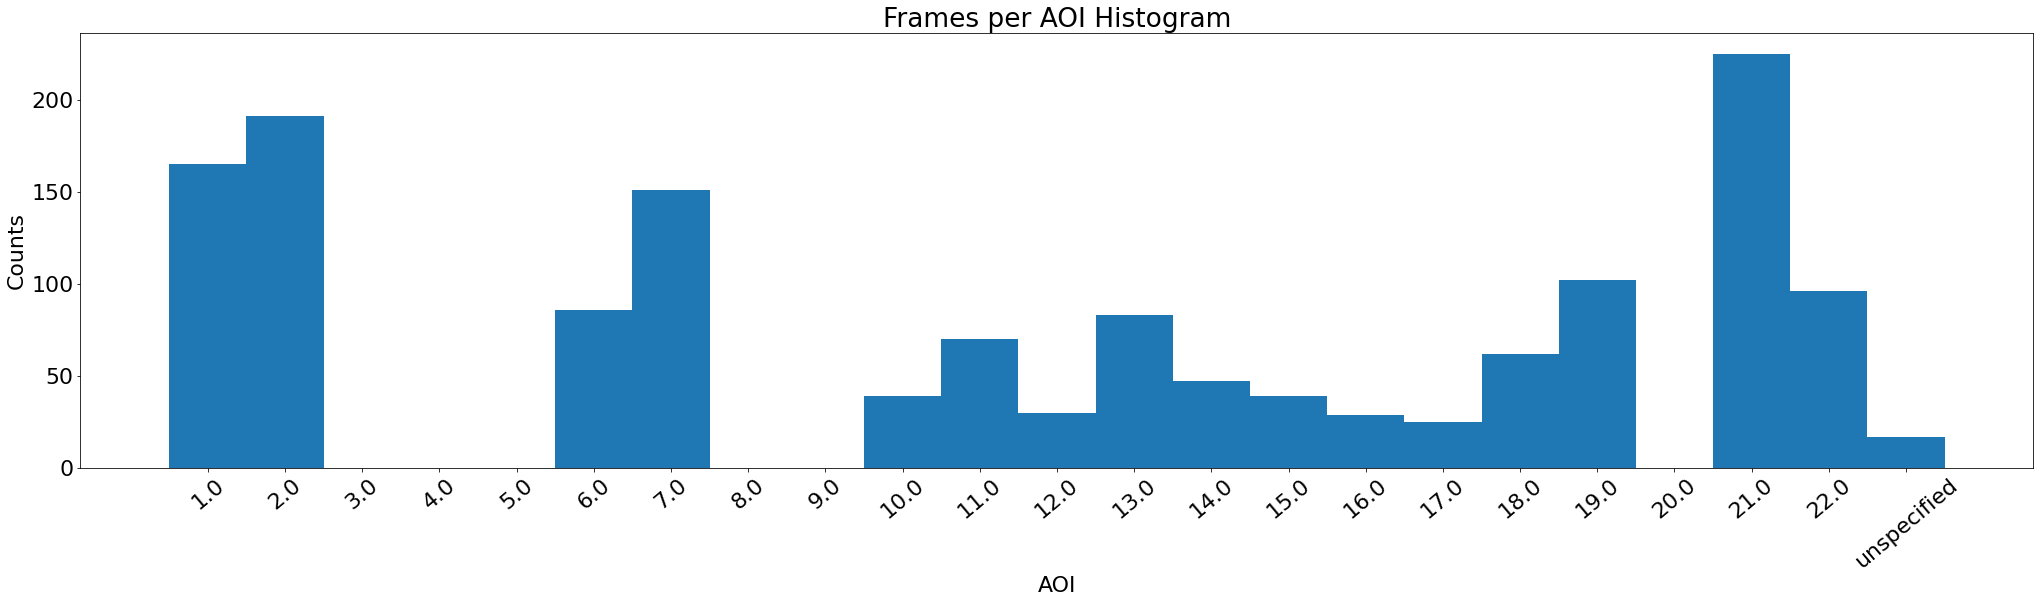

In [ ]:
hist_features(metadata, 'AOI', 1)

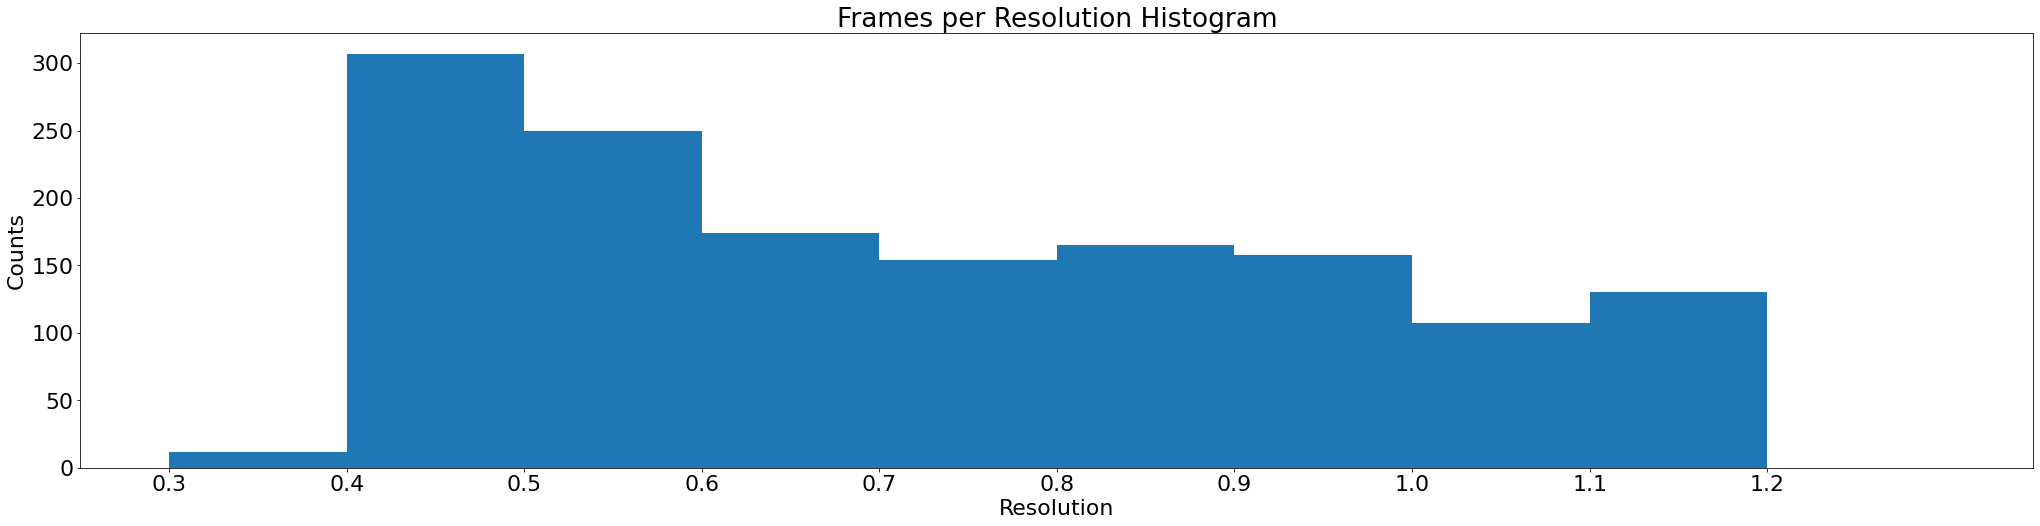

In [ ]:
hist_features(metadata, 'Resolution', 0.1)

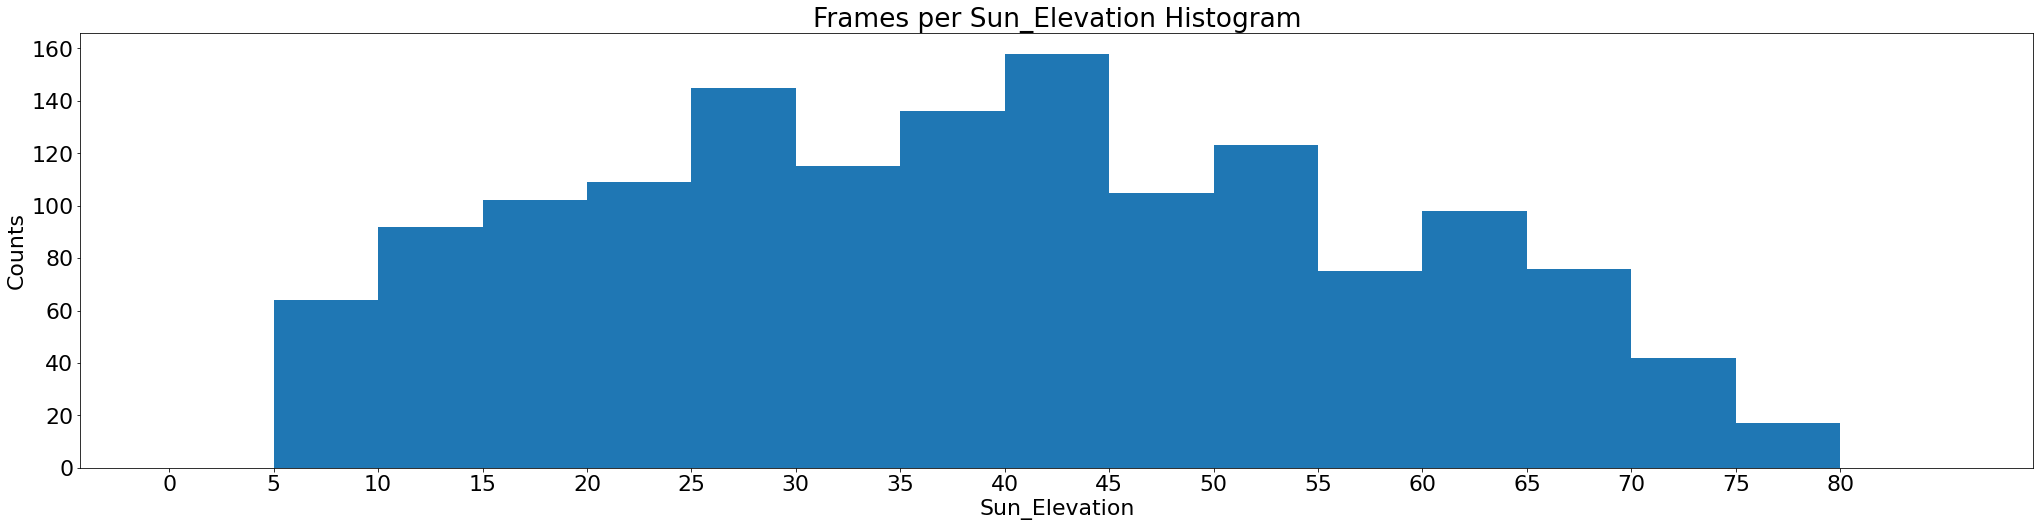

In [ ]:
hist_features(metadata, 'Sun_Elevation', 5)

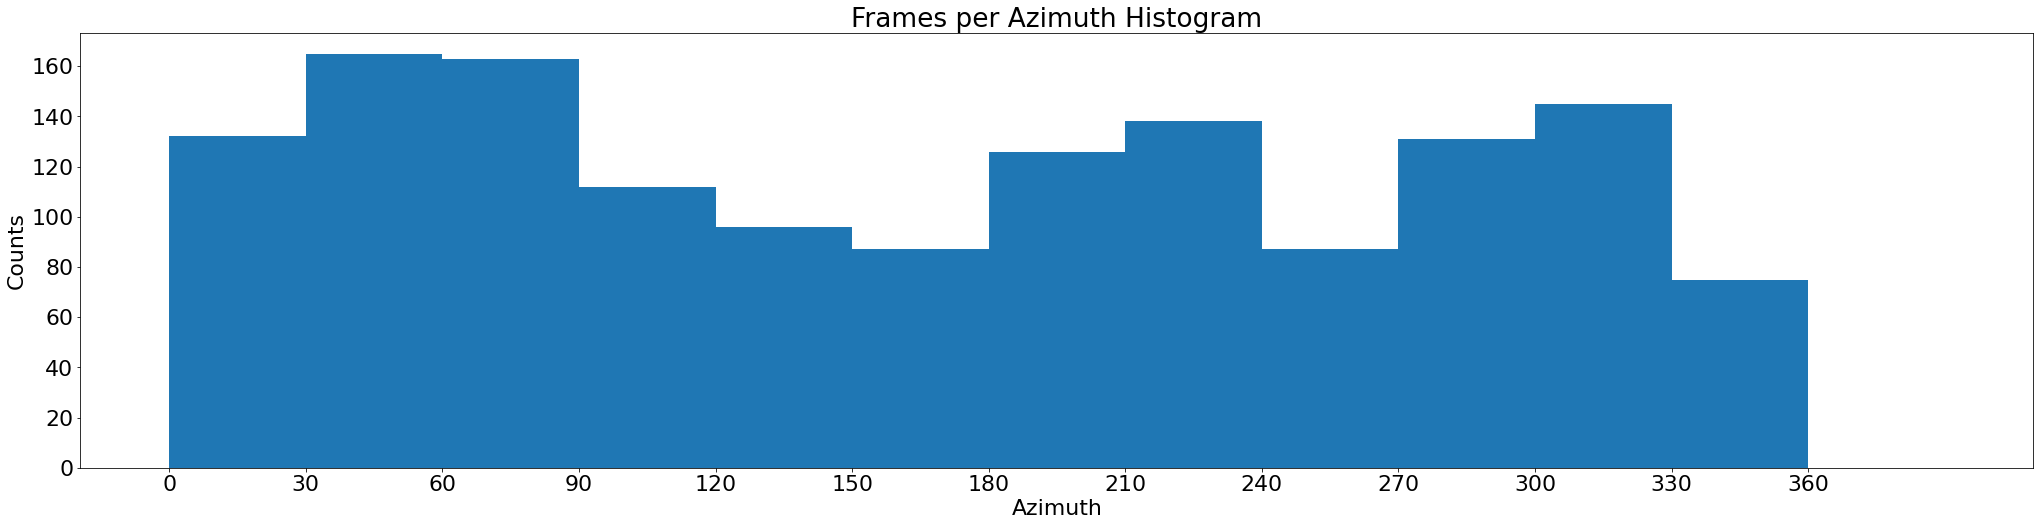

In [ ]:
hist_features(metadata, 'Azimuth', 30)

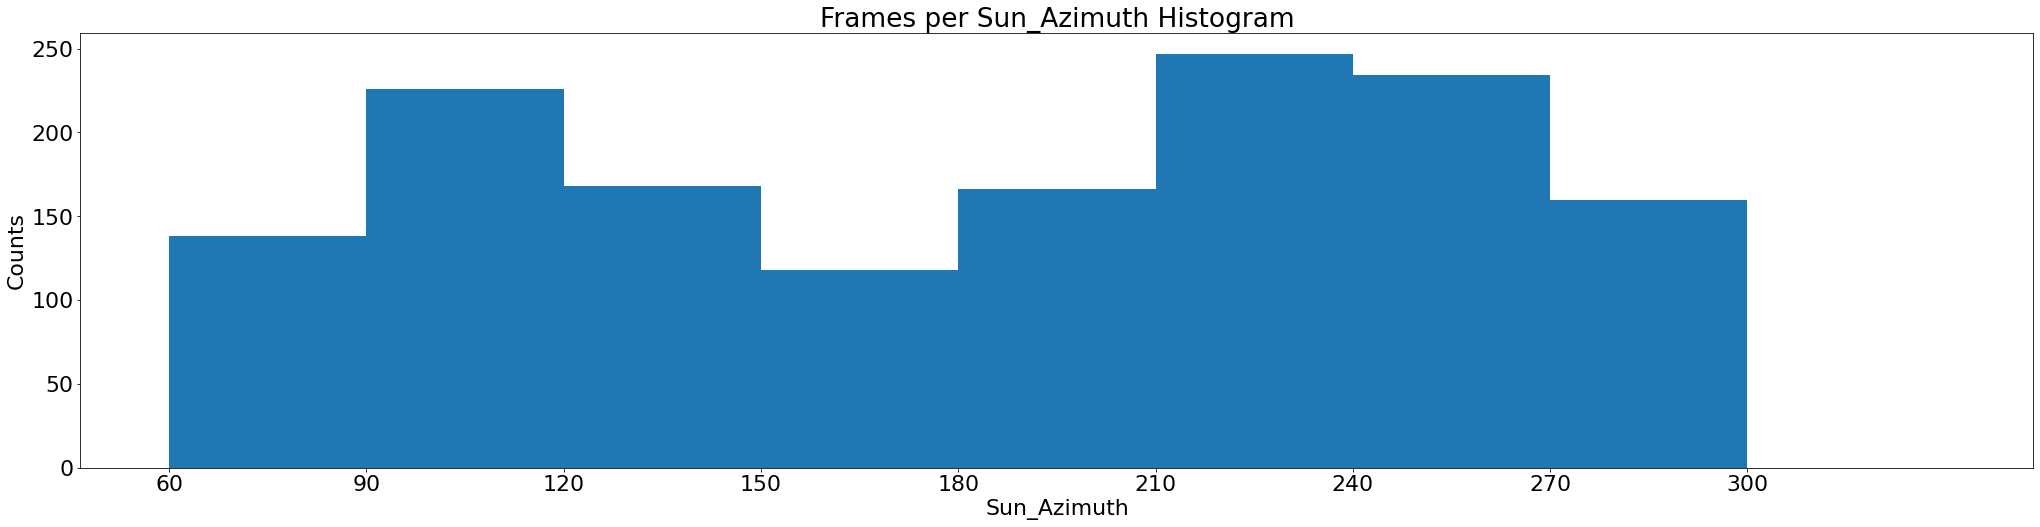

In [ ]:
hist_features(metadata, 'Sun_Azimuth', 30)

####**AOI Analysis**

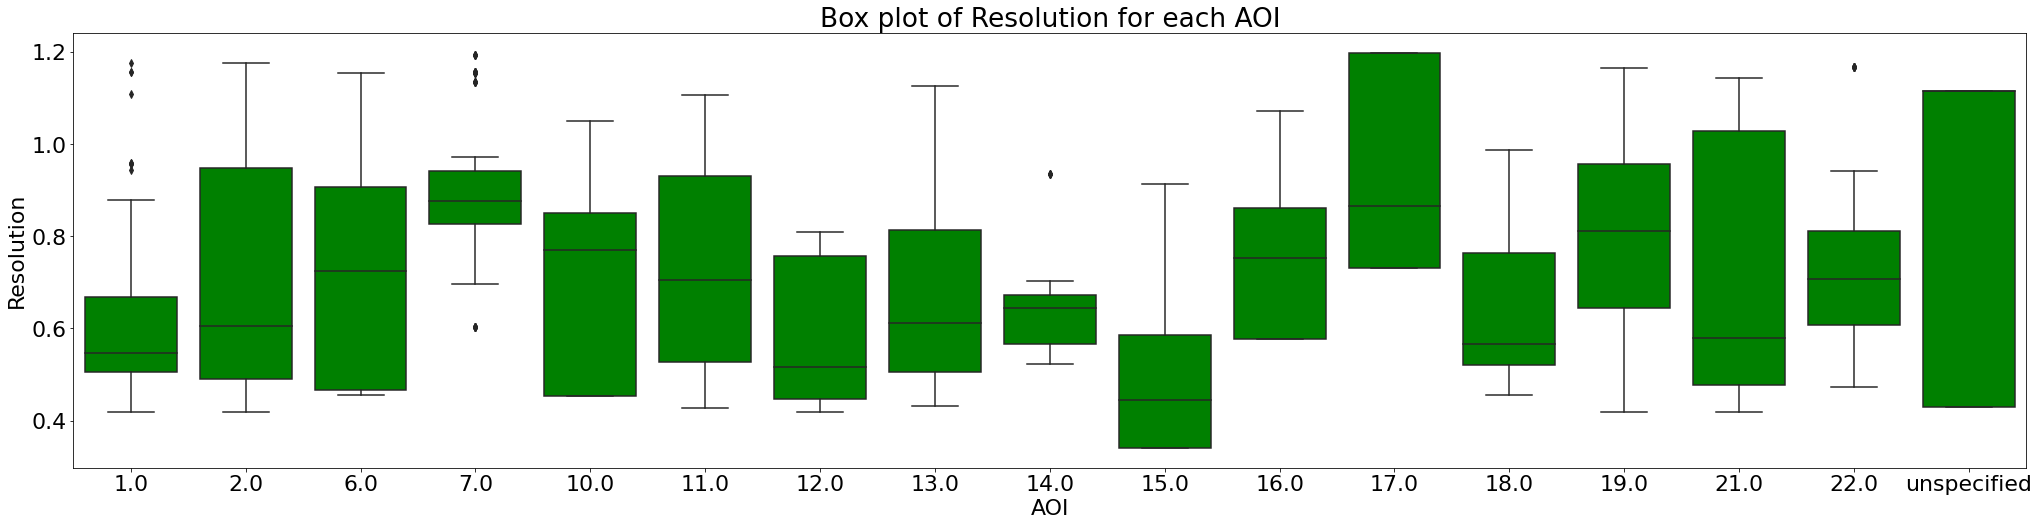

In [ ]:
box_plot_aoi(metadata, 'Resolution')

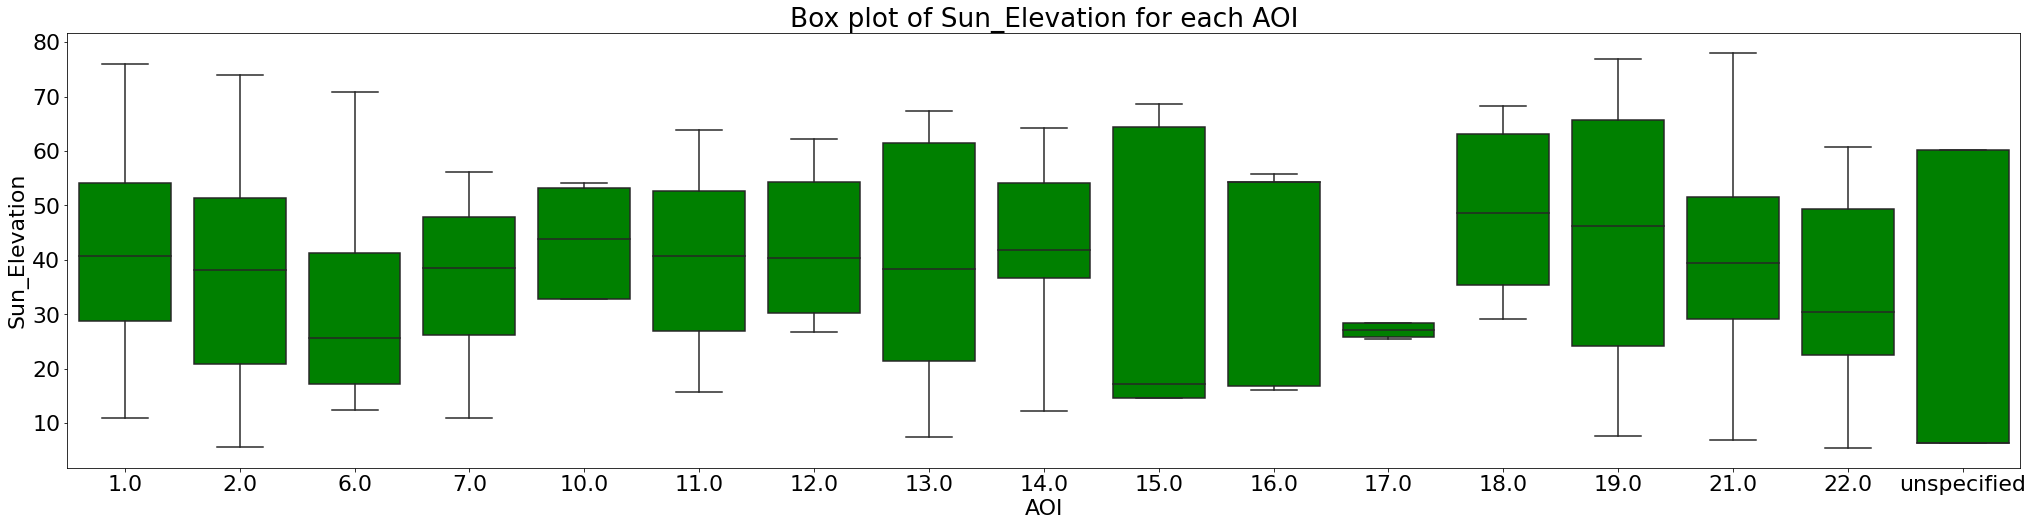

In [ ]:
box_plot_aoi(metadata, 'Sun_Elevation')

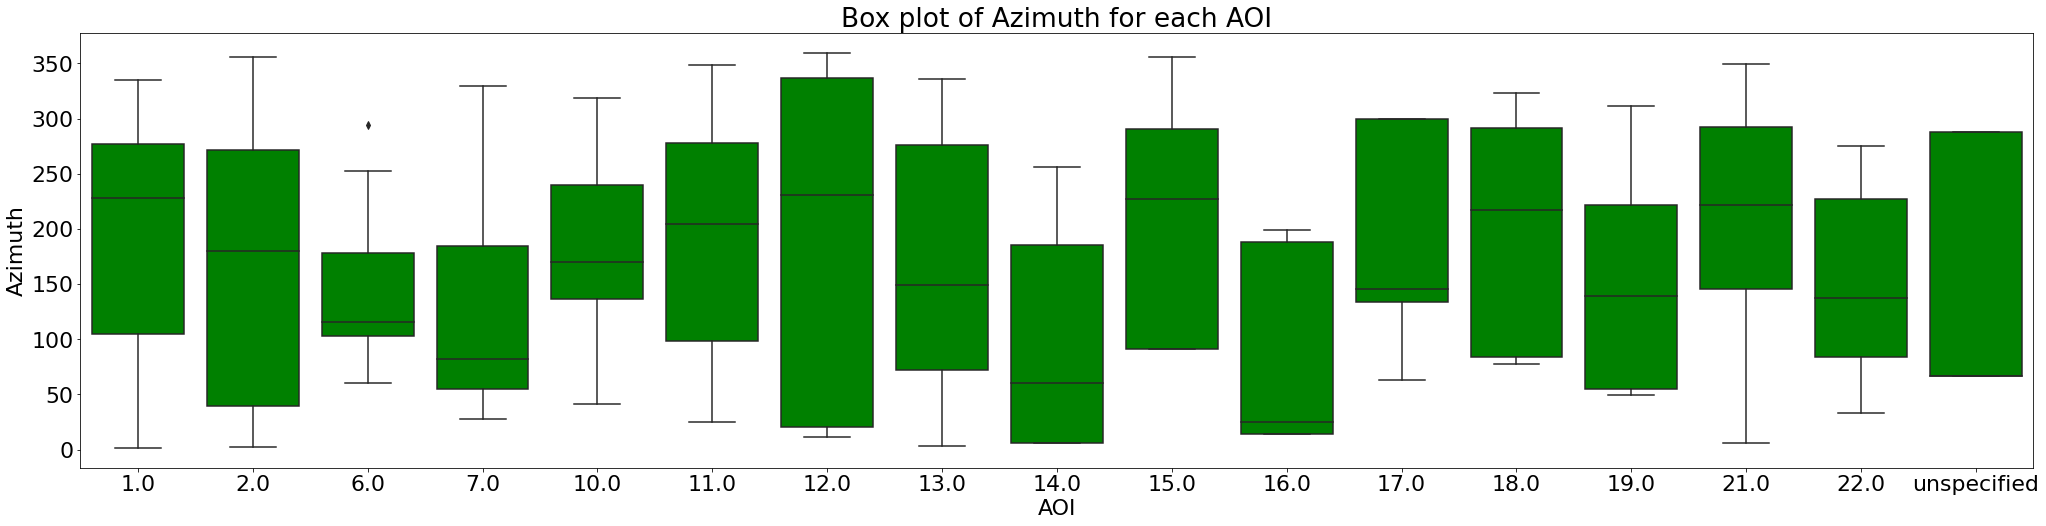

In [ ]:
box_plot_aoi(metadata, 'Azimuth')

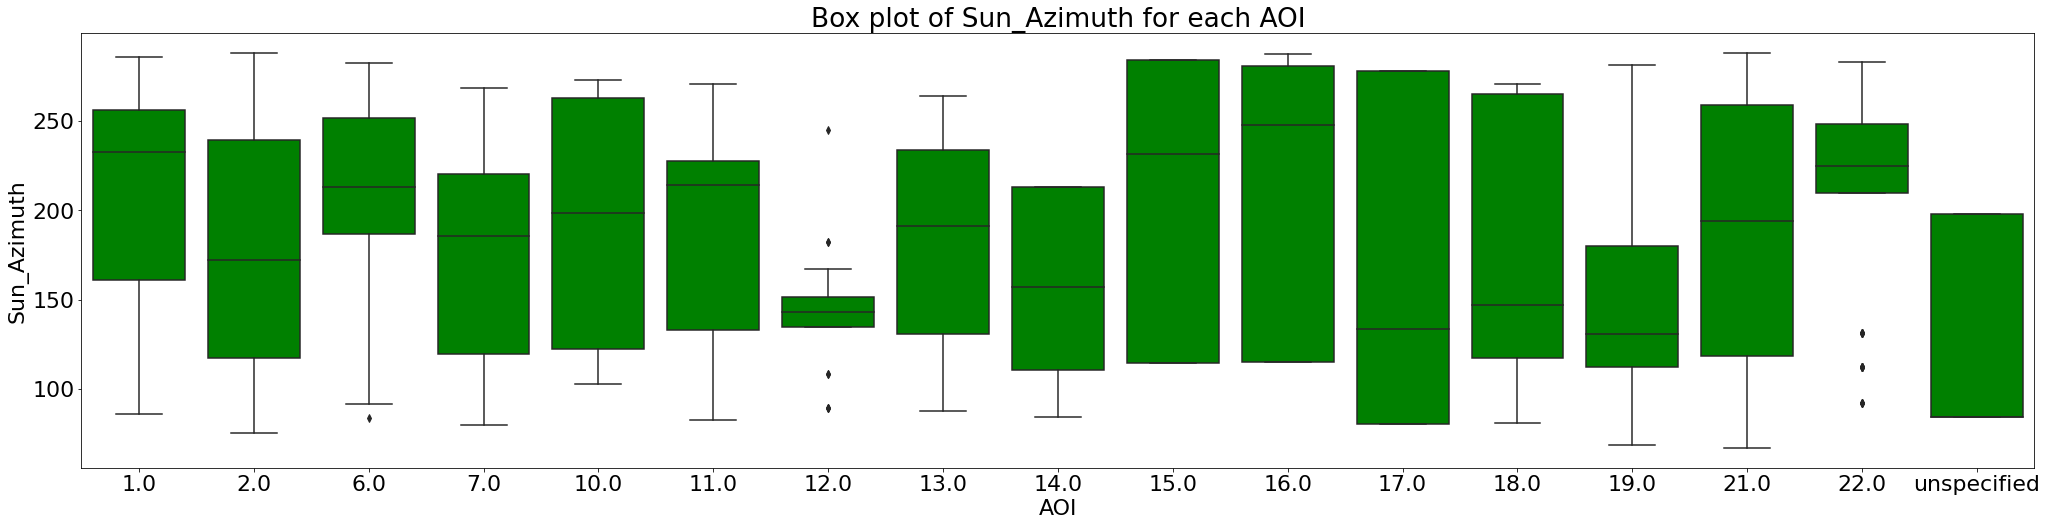

In [ ]:
box_plot_aoi(metadata, 'Sun_Azimuth')

####**Classes Analysis**

In [ ]:
ann_train = ann_train.merge(metadata, how='left', on='Frame')

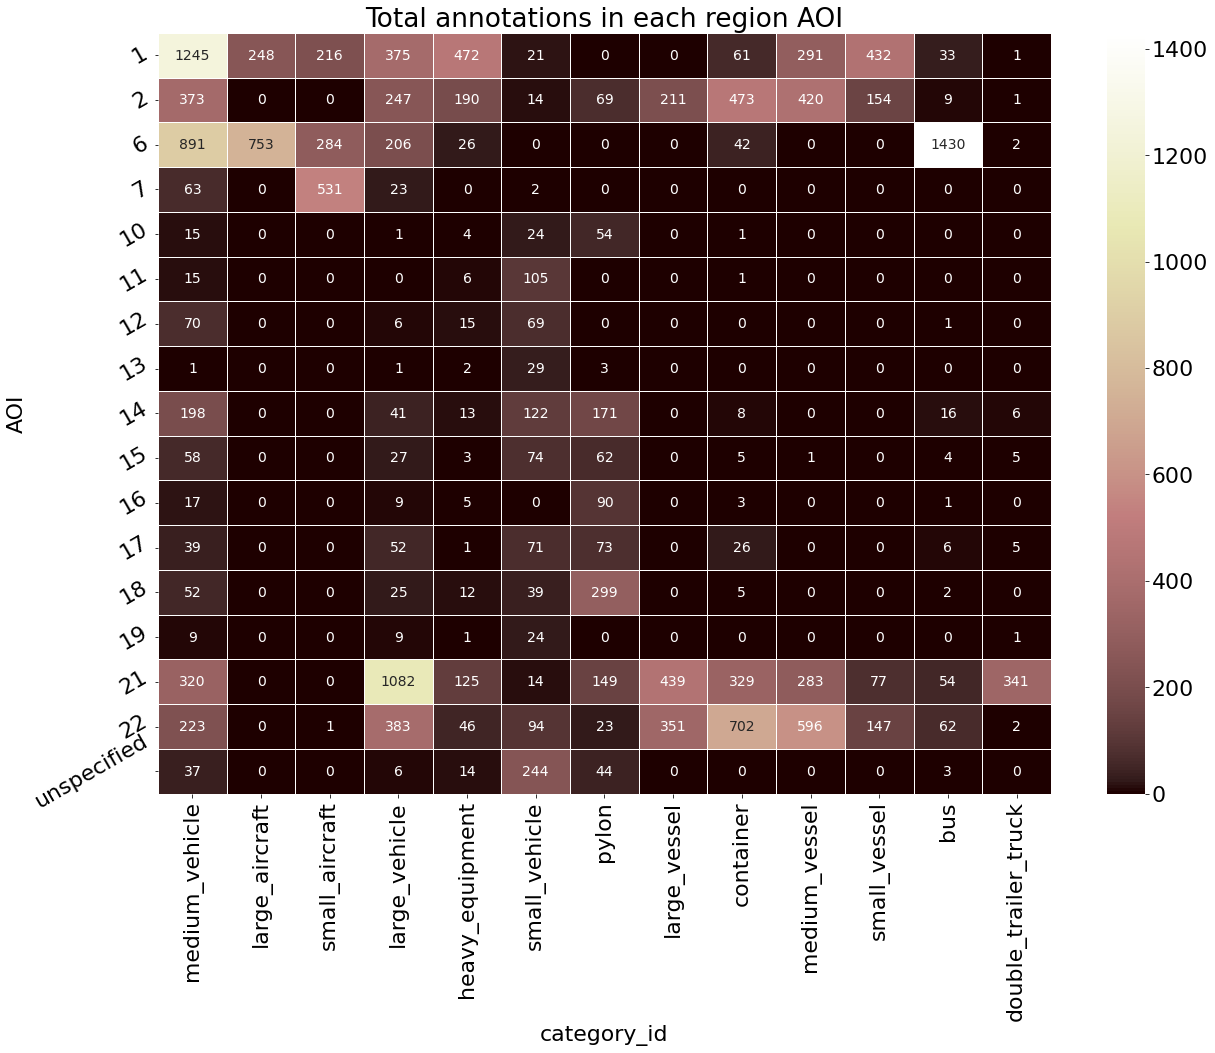

In [ ]:
total_ann_heatmap(ann_train)

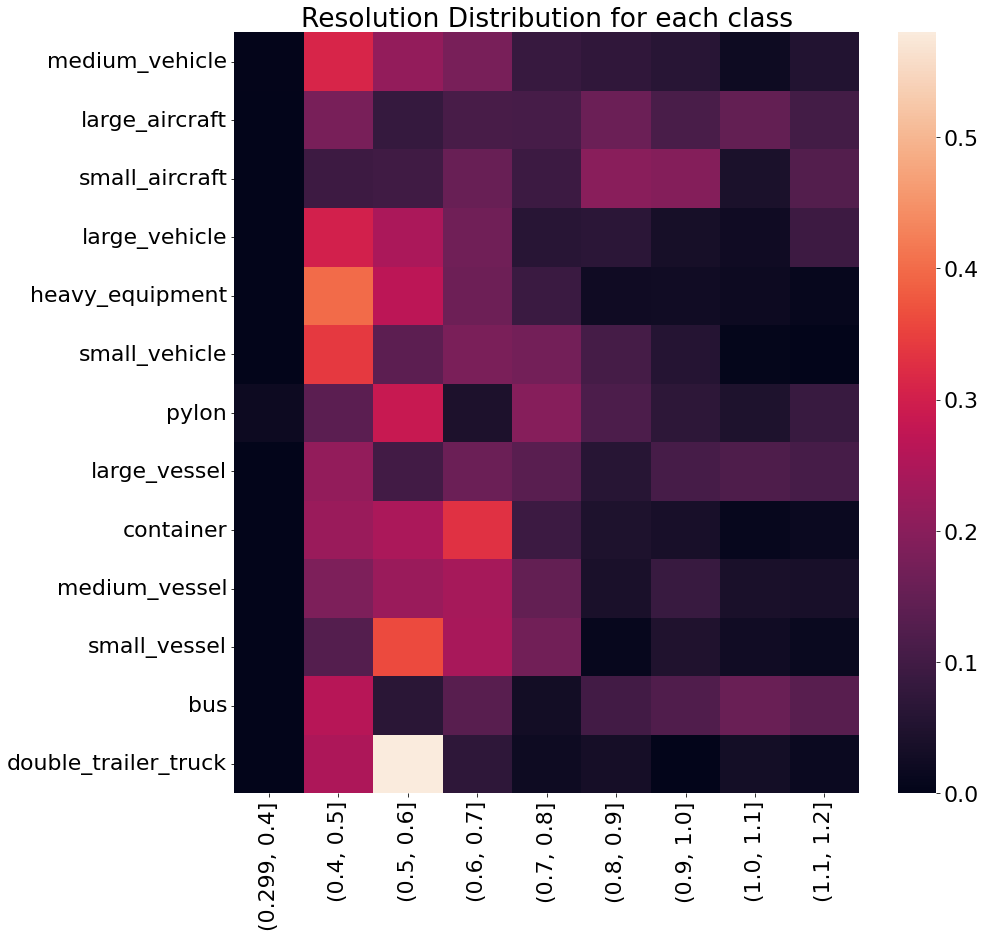

In [ ]:
heatmap_res(ann_train[['category_id', 'Resolution']])

##**Frame and annotations display**

Please write the frame's full name, without the ending '.tiff'

In [ ]:
frame_to_show = "5532_6400_1280" #@param {type:"string"}

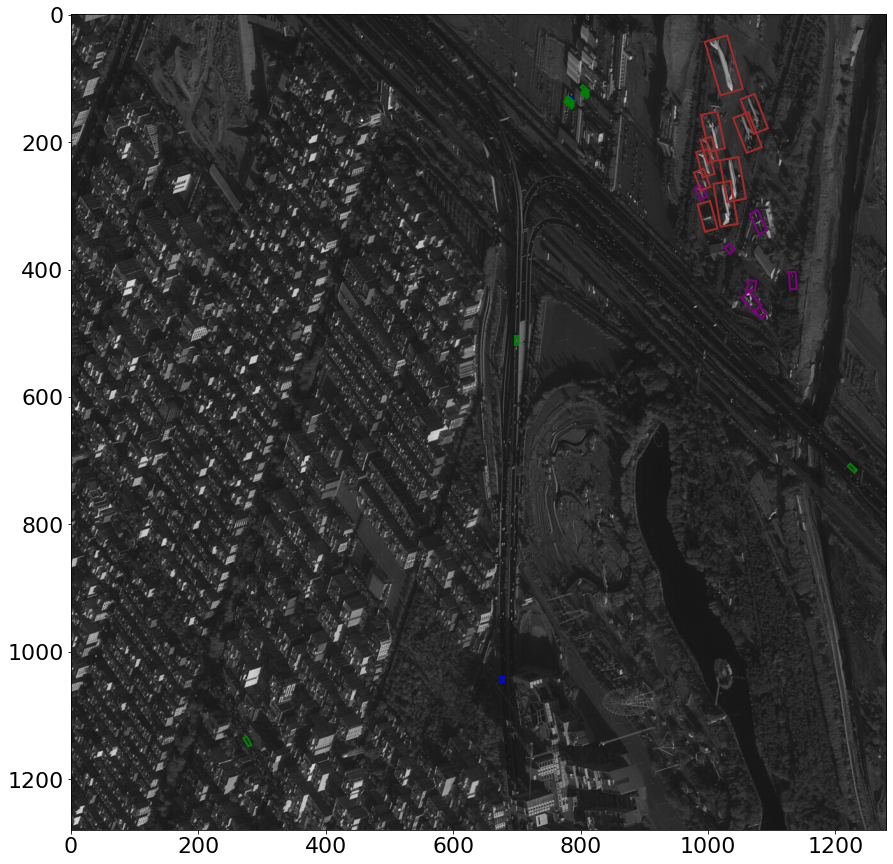

In [ ]:
ann_frame = ann_train[ann_train.Frame == frame_to_show]
frame_path = f"/content/images/{frame_to_show}.tiff"
frame_with_annotation(frame_path, ann_frame)